# Metal Puzzles

Port of [srush/GPU-Puzzles](https://github.com/srush/GPU-Puzzles) to [Metal](https://en.wikipedia.org/wiki/Metal_API) using [MLX Custom Kernels](https://ml-explore.github.io/mlx/build/html/dev/custom_metal_kernels.html). Inspired by [@awnihannun](https://x.com/awnihannun/status/1833376670063202536)!

![Metal Puzzles Logo](./imgs/metal_puzzles.png)

GPUs are crucial in machine learning because they can process data on a massively parallel scale. While it's possible to become an expert in machine learning without writing any GPU code, building intuition is challenging when you're only working through layers of abstraction. Additionally, as models grow in complexity, the need for developers to write efficient, high-performance kernels becomes increasingly important to leverage the power of modern hardware.

Whether you're new to GPU programming or have experience with CUDA, the following puzzles provide a straightforward way to learn on an Apple Silicon computer. In the following exercises, you'll use the `mx.fast.metal_kernel()` function from Apple's [mlx](https://github.com/ml-explore/mlx) framework, which allows you to write custom Metal kernels through a Python/C++ API. For verification purposes, I've created a wrapper class around `mx.fast.metal_kernel()` called `MetalKernel`, but the interface remains identical.

If you're interested in more material, check out the [MLX Custom Metal Kernels Documentation](https://ml-explore.github.io/mlx/build/html/dev/custom_metal_kernels.html) and the [Metal Shading Language specification](https://developer.apple.com/metal/Metal-Shading-Language-Specification.pdf).

In [20]:
import mlx.core as mx
from utils import MetalKernel, MetalProblem

## Puzzle 1: Map

Implement a "kernel" (GPU function) that adds 10 to each position of the array `a` and stores it in the array `out`.  You have 1 thread per position.

**Note:** The `source` string below is the body of your Metal kernel, the function signature will be automatically generated for you. Below you'll notice the `input_names` and `output_names` parameters. These define the parameters for your Metal kernel.

**Tip:** If you need a tool for debugging your Kernel read the *Metal Debugger* section at the bottom of the README. Also, you can print out the generated Metal kernel by setting the environment variable `VERBOSE=1`.

# Map
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 
        


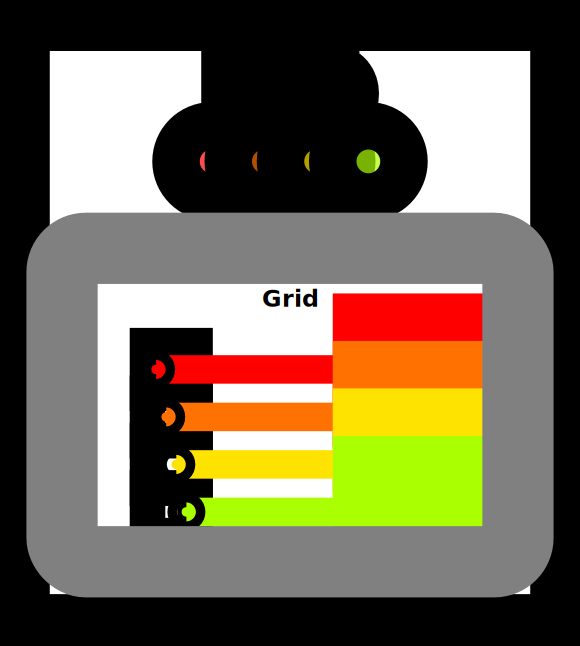

In [21]:
def map_spec(a: mx.array):
    return a + 10


def map_test(a: mx.array):
    source = """
        uint local_i = thread_position_in_grid.x;
        out[local_i] = a[local_i] + 10;
    """

    kernel = MetalKernel(
        name="map",
        input_names=["a"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 4
a = mx.arange(SIZE)
output_shape = (SIZE,)

problem = MetalProblem(
    "Map", map_test, [a], output_shape, grid=(SIZE, 1, 1), spec=map_spec
)

problem.show()

In [22]:
problem.check()

Passed Tests!


## Puzzle 2: Zip 

Implement a kernel that takes two arrays `a` and `b`, adds each element together, and stores the result in the output array `out`. You have 1 thread per position.

# Zip
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 
        


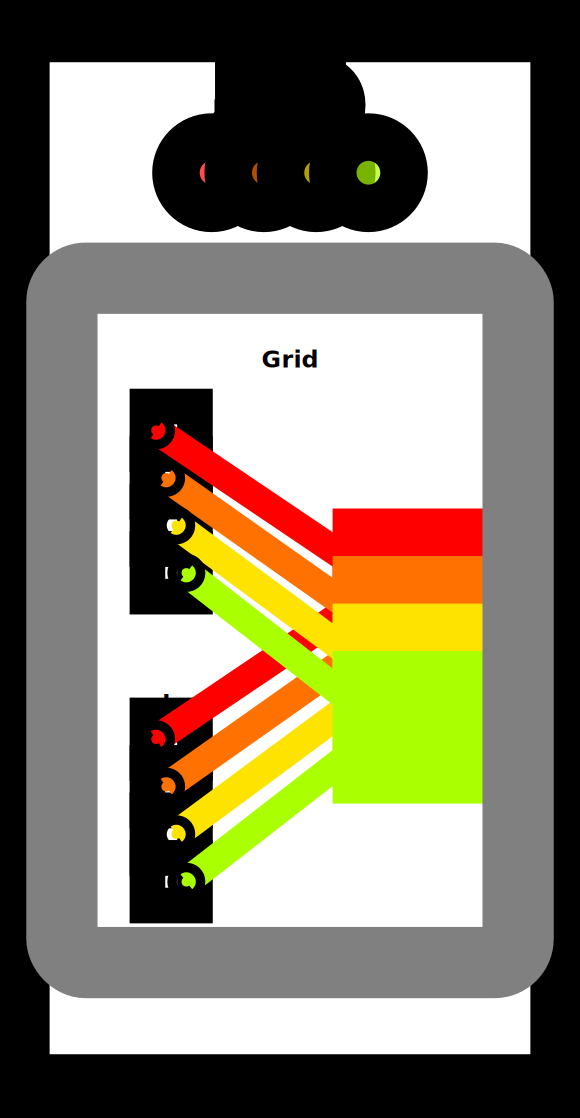

In [23]:
def zip_spec(a: mx.array, b: mx.array):
    return a + b


def zip_test(a: mx.array, b: mx.array):
    source = """
        uint local_i = thread_position_in_grid.x;
        out[local_i] = a[local_i] + b[local_i];
    """

    kernel = MetalKernel(
        name="zip",
        input_names=["a", "b"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 4
a = mx.arange(SIZE)
b = mx.arange(SIZE)
output_shapes = (SIZE,)

problem = MetalProblem(
    "Zip", zip_test, [a, b], output_shapes, grid=(SIZE, 1, 1), spec=zip_spec
)

problem.show()

In [24]:
problem.check()

Passed Tests!


## Puzzle 3: Guard

Implement a kernel that adds 10 to each position of `a` and stores it in `out`. You have more threads than positions.

**Warning:** Be careful of out-of-bounds access.

**Note:** You can append `_shape`, `_strides`, or `_ndim` to any input parameter to automatically add that data as a paramter to your kerenls. So, in the following puzzle you could use `a_shape`, `a_strides`, or `a_ndim`.

# Guard
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 
        


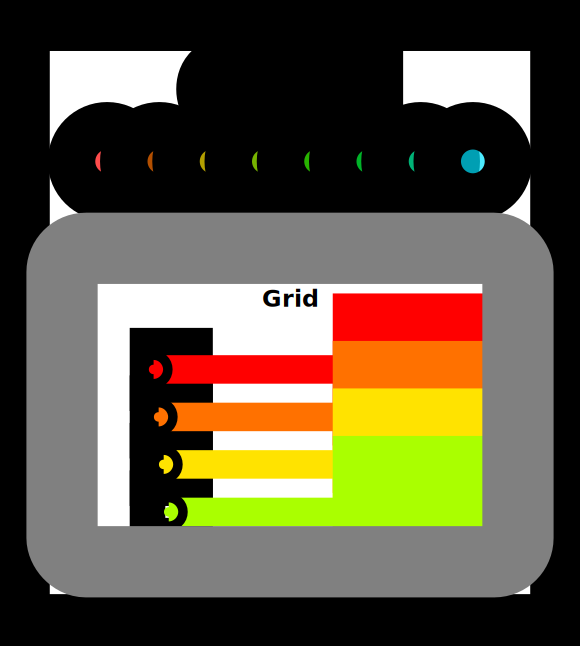

In [25]:
def map_guard_test(a: mx.array):
    source = """
        uint local_i = thread_position_in_grid.x;
        // FILL ME IN (roughly 1-3 lines)
        if (local_i < a_shape[0]) {
            out[local_i] = a[local_i] + 10;
        }
    """

    kernel = MetalKernel(
        name="guard",
        input_names=["a"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 4
a = mx.arange(SIZE)
output_shape = (SIZE,)

problem = MetalProblem(
    "Guard", map_guard_test, [a], output_shape, grid=(8, 1, 1), spec=map_spec
)

problem.show()

In [26]:
problem.check()

Passed Tests!


## Puzzle 4: Map 2D

Implement a kernel that adds 10 to each position of `a` and stores it in `out`. Input `a` is 2D and square. You have more threads than positions.

**Note:** All memory in Metal is represented as a 1D array, so direct 2D indexing is not supported.

# Map 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 
        


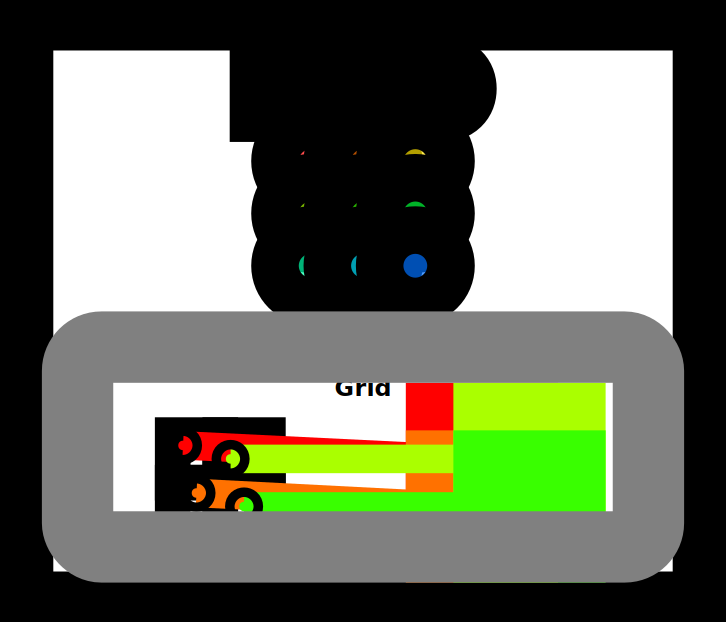

In [27]:
def map_2D_test(a: mx.array):
    source = """
        uint thread_x = thread_position_in_grid.x;
        uint thread_y = thread_position_in_grid.y;
        uint x_size = a_shape[1];
        uint y_size = a_shape[0];
        if (thread_x < x_size && thread_y < y_size) {
            out[thread_y * y_size + thread_x] = a[thread_y * y_size + thread_x] + 10;
        }
    """

    kernel = MetalKernel(
        name="map_2D",
        input_names=["a"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 2
a = mx.arange(SIZE * SIZE).reshape((SIZE, SIZE))
output_shape = (SIZE, SIZE)

problem = MetalProblem(
    "Map 2D", map_2D_test, [a], output_shape, grid=(3, 3, 1), spec=map_spec
)

problem.show()

In [28]:
problem.check()

Passed Tests!


## Puzzle 5: Broadcast

Implement a kernel that adds `a` and `b` and stores it in `out`. Inputs `a` and `b` are arrays. You have more threads than positions.

# Broadcast
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 
        


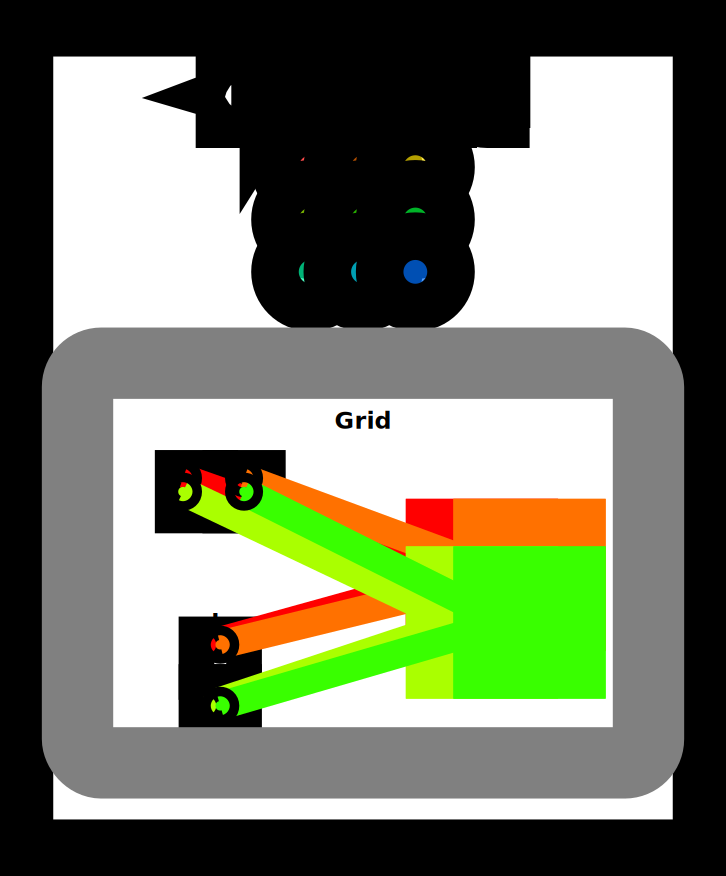

In [29]:
def broadcast_test(a: mx.array, b: mx.array):
    source = """
        uint thread_x = thread_position_in_grid.x;
        uint thread_y = thread_position_in_grid.y;
        uint out_pos = thread_x * a_shape[0] + thread_y;
        if (thread_x < a_shape[0] && thread_y < b_shape[1]) {
            out[out_pos] = a[thread_x] + b[thread_y];
        }
    """

    kernel = MetalKernel(
        name="broadcast",
        input_names=["a", "b"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 2
a = mx.arange(SIZE).reshape(SIZE, 1)
b = mx.arange(SIZE).reshape(1, SIZE)
output_shape = (SIZE, SIZE)

problem = MetalProblem(
    "Broadcast", broadcast_test, [a, b], output_shape, grid=(3, 3, 1), spec=zip_spec
)

problem.show()

In [30]:
problem.check()

Passed Tests!


## Puzzle 6: Threadgroups

Implement a kernel that adds 10 to each position of `a` and stores it in `out`. You have fewer threads per threadgroup than the size of `a`, but more threads than positions.

**Note:** A threadgroup is simply a group of threads within the thread grid. The number of threads per threadgroup is limited to a defined number, but we can have multiple different threadgroups. The Metal parameter `threadgroup_position_in_grid` tells us what threadgroup we are in.

# Threadgroups
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 
        


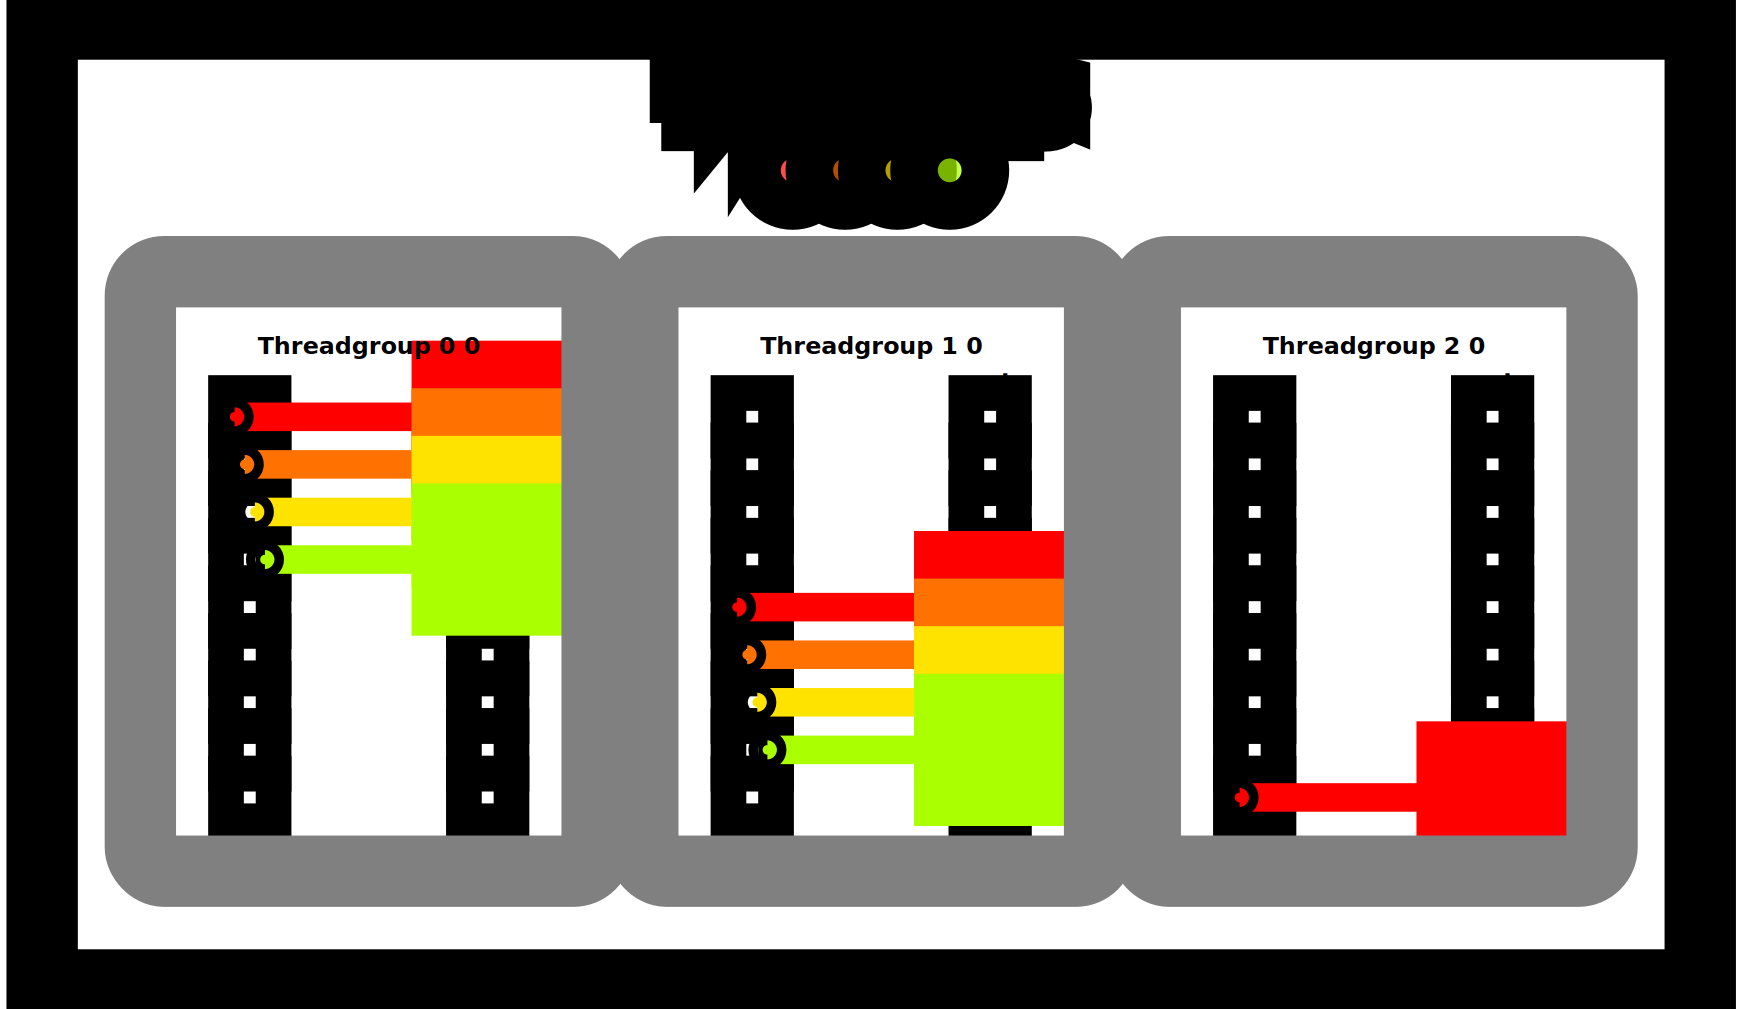

In [31]:
def map_threadgroup_test(a: mx.array):
    source = """
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        if (i < a_shape[0]) {
            out[i] = a[i] + 10;
        }
    """

    kernel = MetalKernel(
        name="threadgroups",
        input_names=["a"],
        output_names=["out"],
        source=source,
    )

    return kernel

SIZE = 9
a = mx.arange(SIZE)
output_shape = (SIZE,)

problem = MetalProblem(
    "Threadgroups",
    map_threadgroup_test,
    [a],
    output_shape,
    grid=(12,1,1),
    threadgroup=(4,1,1),
    spec=map_spec
)

problem.show()

In [32]:
problem.check()

Passed Tests!


## Puzzle 7: Threadgroups 2D

Implement the same kernel in 2D. You have fewer threads per threadgroup than the size of `a` in both directions, but more threads than positions in the grid.

# Threadgroups 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 
        


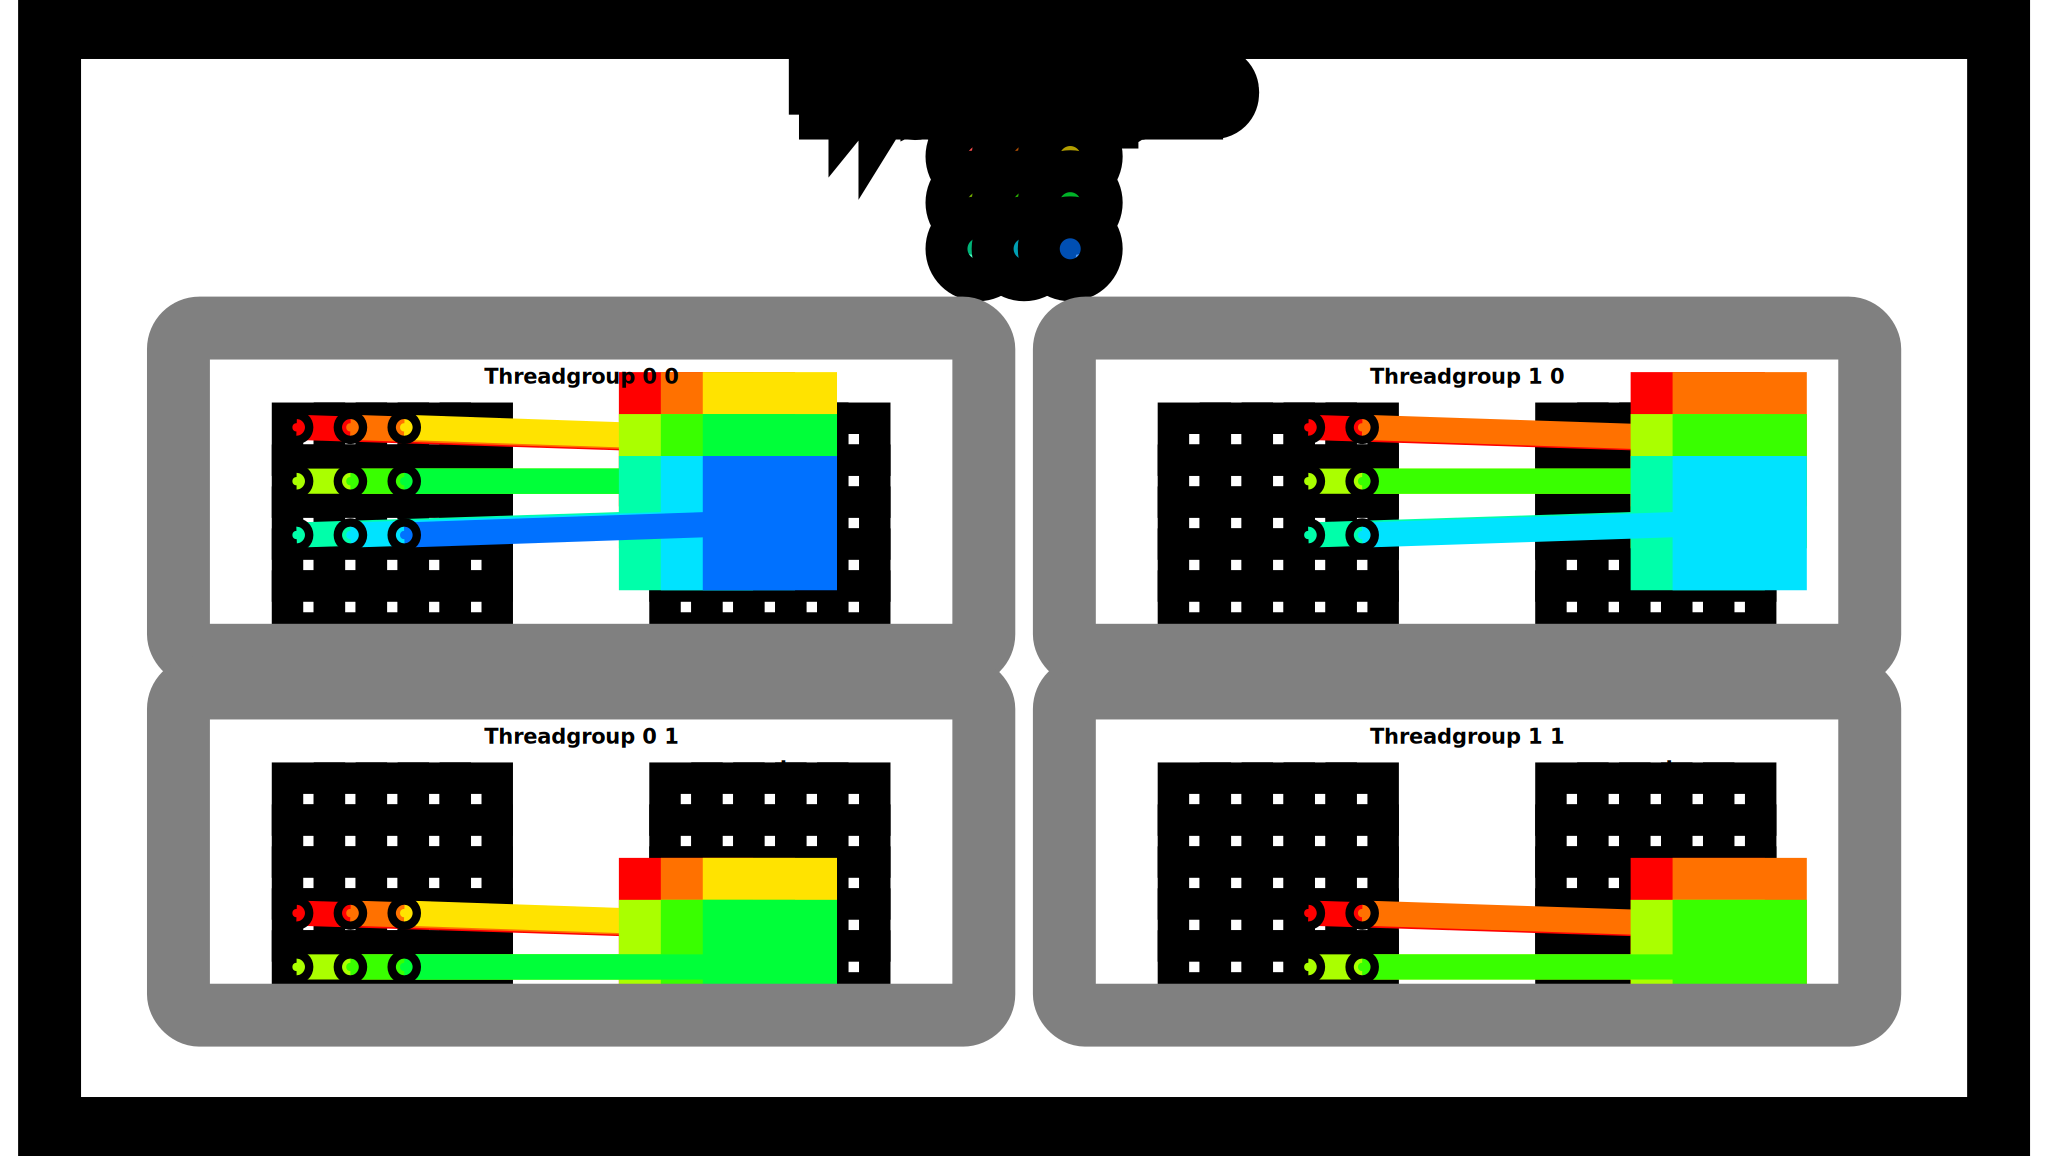

In [33]:
def map_threadgroup_2D_test(a: mx.array):
    source = """
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint j = threadgroup_position_in_grid.y * threads_per_threadgroup.y + thread_position_in_threadgroup.y;
        if (i < a_shape[0] && j < a_shape[1]) {
            out[i*a_shape[0] + j] = a[i*a_shape[0] + j] + 10;
        }
    """

    kernel = MetalKernel(
        name="threadgroups_2D",
        input_names=["a"],
        output_names=["out"],
        source=source,
    )

    return kernel


SIZE = 5
a = mx.ones((SIZE, SIZE))
output_shape = (SIZE, SIZE)

problem = MetalProblem(
    "Threadgroups 2D",
    map_threadgroup_2D_test,
    [a],
    output_shape,
    grid=(6, 6, 1),
    threadgroup=(3, 3, 1),
    spec=map_spec,
)

problem.show()

In [34]:
problem.check()

Passed Tests!


## Puzzle 8: Threadgroup Memory

Implement a kernel that adds 10 to each position of `a` and stores it in `out`. You have fewer threads per threadgroup than the size of `a`.

**Warning**: Each threadgroup can only have a *constant* amount of threadgroup memory that the threads can read and write to. After writing to threadgroup memory, you need to call `threadgroup_barrier(mem_flags::mem_threadgroup)` to ensure that threads are synchronized. In this puzzle we add the `header` variable as a new parameter to the `MetalKernel` object, which simply defines values outside of the kernel body (often used for header imports).

For more information read section [4.4 Threadgroup Address Space](https://developer.apple.com/metal/Metal-Shading-Language-Specification.pdf#page=86) and section [6.9 Synchronization and SIMD-Group Functions](https://developer.apple.com/metal/Metal-Shading-Language-Specification.pdf#page=177) in the Metal Shading Language Specification.

(This example does not really need threadgroup memory or synchronization, but it's a demo.)

In [ ]:
def shared_test(a: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 4;
    """

    source = """
        threadgroup float shared[THREADGROUP_MEM_SIZE];
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;

        if (i < a_shape[0]) {
            shared[local_i] = a[i];
            threadgroup_barrier(mem_flags::mem_threadgroup);
        }

        // FILL ME IN (roughly 1-3 lines)
    """

    kernel = MetalKernel(
        name="threadgroup_memory",
        input_names=["a"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

SIZE = 8
a = mx.ones(SIZE)
output_shape = (SIZE,)

problem = MetalProblem(
    "Threadgroup Memory",
    shared_test,
    [a],
    output_shape,
    grid=(SIZE,1,1),
    threadgroup=(4,1,1),
    spec=map_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 9: Pooling

Implement a kernel that sums together the last 3 position of `a` and stores it in `out`. You have 1 thread per position. 

**Note:** `threadgroup` memory is often faster than sharing data in `device` memory because it is located closer the the GPU's compute units. Be careful of uncessary reads and writes from global parameters (`a` and `out`), since their data is stored in `device` memory. You only need 1 global read and 1 global write per thread.

**Tip:** Remember to be careful about syncing.

In [ ]:
def pooling_spec(a: mx.array):
    out = mx.zeros(*a.shape)
    for i in range(a.shape[0]):
        out[i] = a[max(i - 2, 0) : i + 1].sum()
    return out

def pooling_test(a: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 8;
    """

    source = """
        threadgroup float shared[THREADGROUP_MEM_SIZE];
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;
        // FILL ME IN (roughly 11 lines)
    """

    kernel = MetalKernel(
        name="pooling",
        input_names=["a"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

SIZE = 8
a = mx.arange(SIZE)
output_shape = (SIZE,)

problem = MetalProblem(
    "Pooling",
    pooling_test,
    [a],
    output_shape,
    grid=(SIZE,1,1),
    threadgroup=(SIZE,1,1),
    spec=pooling_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 10: Dot Product

Implement a kernel that computes the [dot product](https://en.wikipedia.org/wiki/Dot_product#Coordinate_definition) of `a` and `b` and stores it in `out`. You have 1 thread per position. You only need 2 global reads and 1 global write per thread.

**Note**: For this problem you don't need to worry about number of reads to the `threadgroup` memory. We will handle that challenge later.

In [ ]:
def dot_spec(a: mx.array, b: mx.array):
    return a @ b

def dot_test(a: mx.array, b: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 8;
    """

    source = """
        threadgroup float shared[THREADGROUP_MEM_SIZE];
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;
        // FILL ME IN (roughly 11 lines)
    """

    kernel = MetalKernel(
        name="dot_product",
        input_names=["a", "b"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

SIZE = 8
a = mx.arange(SIZE, dtype=mx.float32)
b = mx.arange(SIZE, dtype=mx.float32)
output_shape = (1,)

problem = MetalProblem(
    "Dot Product",
    dot_test,
    [a, b],
    output_shape,
    grid=(SIZE,1,1),
    threadgroup=(SIZE,1,1),
    spec=dot_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 11: 1D Convolution

Implement a kernel that computes a 1D convolution between `a` and `b` and stores it in `out`. You need to handle the general case. You only need 2 global reads and 1 global write per thread.

In [ ]:
def conv_spec(a: mx.array, b: mx.array):
    out = mx.zeros(*a.shape)
    len = b.shape[0]
    for i in range(a.shape[0]):
        out[i] = sum([a[i + j] * b[j] for j in range(len) if i + j < a.shape[0]])
    return out

def conv_test(a: mx.array, b: mx.array):
    header = """
        constant uint THREADGROUP_MAX_CONV_SIZE = 12;
        constant uint MAX_CONV_SIZE = 4;
    """

    source = """
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;
        // FILL ME IN (roughly 24 lines)
    """

    kernel = MetalKernel(
        name="1D_conv",
        input_names=["a", "b"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

# Test 1
SIZE = 6
CONV = 3
a = mx.arange(SIZE, dtype=mx.float32)
b = mx.arange(CONV, dtype=mx.float32)
output_shape = (SIZE,)

problem = MetalProblem(
    "1D Conv (Simple)",
    conv_test,
    [a, b],
    output_shape,
    grid=(8,1,1),
    threadgroup=(8,1,1),
    spec=conv_spec
)

problem.show()


In [ ]:
problem.check()

In [ ]:
# Test 2
a = mx.arange(15, dtype=mx.float32)
b = mx.arange(4, dtype=mx.float32)
output_shape = (15,)

problem = MetalProblem(
    "1D Conv (Full)",
    conv_test,
    [a, b],
    output_shape,
    grid=(16,1,1),
    threadgroup=(8,1,1),
    spec=conv_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 12: Prefix Sum

Implement a kernel that computes a sum over `a` and stores it in `out`. If the size of `a` is greater than the threadgroup size, only store the sum of each threadgroup.

We will do this using the [parallel prefix sum](https://en.wikipedia.org/wiki/Prefix_sum#Parallel_algorithms) algorithm in `threadgroup` memory. In each step, the algorithm will sum half of the remaining elements together.

In [ ]:
THREADGROUP_MEM_SIZE = 8
def prefix_sum_spec(a: mx.array):
    out = mx.zeros((a.shape[0] + THREADGROUP_MEM_SIZE - 1) // THREADGROUP_MEM_SIZE)
    for j, i in enumerate(range(0, a.shape[-1], THREADGROUP_MEM_SIZE)):
        out[j] = a[i : i + THREADGROUP_MEM_SIZE].sum()
    return out

def prefix_sum_test(a: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 8;
    """

    source = """
        threadgroup float cache[THREADGROUP_MEM_SIZE];
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;
        // FILL ME IN (roughly 14 lines)
    """

    kernel = MetalKernel(
        name="prefix_sum",
        input_names=["a"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

# Test 1
SIZE = 8
a = mx.arange(SIZE)
output_shape = (1,)

problem = MetalProblem(
    "Prefix Sum (Simple)",
    prefix_sum_test,
    [a],
    output_shape,
    grid=(8,1,1),
    threadgroup=(8,1,1),
    spec=prefix_sum_spec
)

problem.show()

In [ ]:
problem.check()

In [ ]:
# Test 2
SIZE = 15
a = mx.arange(SIZE)
output_shape = (2,)

problem = MetalProblem(
    "Prefix Sum (Full)",
    prefix_sum_test,
    [a],
    output_shape,
    grid=(16,1,1),
    threadgroup=(8,1,1),
    spec=prefix_sum_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 13: Axis Sum

Implement a kernel that computes the sum over each column in the input array `a` and stores it in `out`.

In [ ]:
THREADGROUP_MEM_SIZE = 8
def axis_sum_spec(a: mx.array):
    out = mx.zeros((a.shape[0], (a.shape[1] + THREADGROUP_MEM_SIZE - 1) // THREADGROUP_MEM_SIZE))
    for j, i in enumerate(range(0, a.shape[-1], THREADGROUP_MEM_SIZE)):
        out[..., j] = a[..., i : i + THREADGROUP_MEM_SIZE].sum(-1)
    return out

def axis_sum_test(a: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 8;
    """

    source = """
        threadgroup float cache[THREADGROUP_MEM_SIZE];
        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint local_i = thread_position_in_threadgroup.x;
        uint batch = threadgroup_position_in_grid.y;
        // FILL ME IN (roughly 16 lines)
    """

    kernel = MetalKernel(
        name="axis_sum",
        input_names=["a"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

BATCH = 4
SIZE = 6
a = mx.arange(BATCH * SIZE).reshape((BATCH, SIZE))
output_shape = (BATCH, 1)

problem = MetalProblem(
    "Axis Sum",
    axis_sum_test,
    [a],
    output_shape,
    grid=(8,BATCH,1),
    threadgroup=(8,1,1),
    spec=axis_sum_spec
)

problem.show()

In [ ]:
problem.check()

## Puzzle 14: Matrix Multiply

Implement a kernel that multiplies square matrices `a` and `b` and stores the result in `out`.

**Tip**: The most efficient algorithm will copy a block of data into `threadgroup` memory before computing each of the individual row-column dot products. This is straightforward if the matrix fits entirely in `threadgroup` memory (start by implementing that case first). Then, modify your code to compute partial dot products and iteratively move portions of the matrix into `threadgroup` memory. You should be able to handle the hard test in 6 device memory reads.

In [ ]:
def matmul_spec(a: mx.array, b: mx.array):
    return a @ b

def matmul_test(a: mx.array, b: mx.array):
    header = """
        constant uint THREADGROUP_MEM_SIZE = 3;
    """

    source = """
        threadgroup float a_shared[THREADGROUP_MEM_SIZE][THREADGROUP_MEM_SIZE];
        threadgroup float b_shared[THREADGROUP_MEM_SIZE][THREADGROUP_MEM_SIZE];

        uint i = threadgroup_position_in_grid.x * threads_per_threadgroup.x + thread_position_in_threadgroup.x;
        uint j = threadgroup_position_in_grid.y * threads_per_threadgroup.y + thread_position_in_threadgroup.y;

        uint local_i = thread_position_in_threadgroup.x;
        uint local_j = thread_position_in_threadgroup.y;
        // FILL ME IN (roughly 19 lines)
    """

    kernel = MetalKernel(
        name="matmul",
        input_names=["a", "b"],
        output_names=["out"],
        header=header,
        source=source,
    )

    return kernel

# Test 1
SIZE = 2
a = mx.arange(SIZE * SIZE, dtype=mx.float32).reshape((SIZE, SIZE))
b = mx.arange(SIZE * SIZE, dtype=mx.float32).reshape((SIZE, SIZE)).T
output_shape = (SIZE, SIZE)

problem = MetalProblem(
    "Matmul (Simple)",
    matmul_test,
    [a, b],
    output_shape,
    grid=(3,3,1),
    threadgroup=(3,3,1),
    spec=matmul_spec
)

problem.show()

In [ ]:
problem.check()

In [ ]:
# Test 2
SIZE = 8
a = mx.arange(SIZE * SIZE, dtype=mx.float32).reshape((SIZE, SIZE))
b = mx.arange(SIZE * SIZE, dtype=mx.float32).reshape((SIZE, SIZE)).T
output_shape = (SIZE, SIZE)

problem = MetalProblem(
    "Matmul (Full)",
    matmul_test,
    [a, b],
    output_shape,
    grid=(9,9,1),
    threadgroup=(3,3,1),
    spec=matmul_spec
)

problem.show()

In [ ]:
problem.check()